$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\mymatrix}[2]{\left[ \begin{array}{#1} #2\end{array} \right]} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $

<table style="background-color: transparent;">
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%" align="center"><font size="7" color="#f25625">Computación Cuántica</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="black">Temas Selectos de Ingeniería en Computación I</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="black">2024-2</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="6" color="#f25625">Laboratorio 7: Quantum Machine Learning II</font></td>
    </tr>
</table>

## Contenido

1. [Máquinas de vectores de soporte](#1)
   1. [Support Vector Machine (SVM)](#1.1)
   2. [Métodos de Kernel para Machine Learning](#1.2)
   3. [Kernels cuánticos](#1.3)
   4. [Clasificación](#1.4)
   5. [Agrupación (Clustering)](#1.5)
2. [Red generativa adversativa](#2)
   1. [Generative Adversarial Network (GAN)](#2.1)
   2. [Quantum GAN (qGAN)](#2.2)

<a id="1"></a>
# 1. Máquinas de vectores de soporte

<a id="1.1"></a>
## 1.A Support Vector Machine (SVM)

**Support Vector Machine (SVM)** es un potente algoritmo de machine learning que se utiliza para tareas de clasificación, regresión e incluso detección de valores atípicos lineales o no lineales. Las SVM se pueden utilizar para una variedad de tareas, como clasificación de texto, clasificación de imágenes, detección de spam, identificación de escritura a mano, análisis de expresión genética, detección de rostros y detección de anomalías. Las SVM son adaptables y eficientes en una variedad de aplicaciones porque pueden gestionar datos de alta dimensión y relaciones no lineales.

Los algoritmos SVM son muy efectivos cuando intentamos encontrar el hiperplano de separación máximo entre las diferentes clases disponibles en la característica de destino.

### Objetivo

El objetivo principal del algoritmo SVM es encontrar el **hiperplano** óptimo en un espacio $N$-dimensional que pueda separar los puntos de datos en diferentes clases en el espacio de características. El hiperplano intenta que el _margen_ entre los puntos más cercanos de diferentes clases sea el _máximo posible_. La dimensión del hiperplano depende de la cantidad de características. Si el número de características de entrada es dos, entonces el hiperplano es solo una línea. Si el número de entidades de entrada es tres, entonces el hiperplano se convierte en un plano 2D. Resulta difícil imaginar cuando el número de características supera tres.

Consideremos dos variables independientes $x_1$, $x_2$ y una variable dependiente que es represetada por el color azul o rojo.

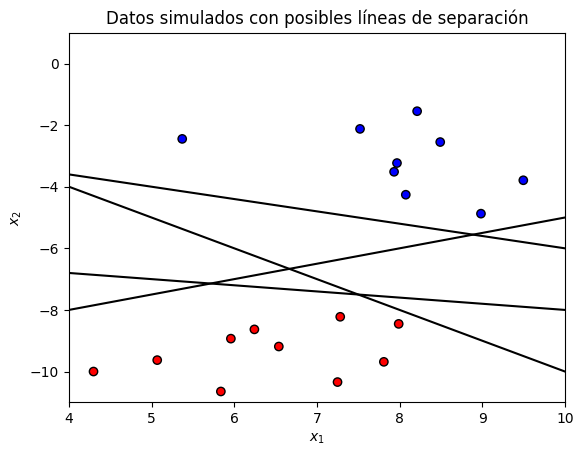

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generar datos simulados
X, y = make_blobs(n_samples=20, centers=2, random_state=6)
y = 2 * y - 1  # Convertir las etiquetas a -1 y 1 para conveniencia

# Dibujar los puntos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')

# Definir varias posibles líneas de separación
x_fit = np.linspace(4, 10, 100)
for slope, intercept in [(-1.0, 0.0), (0.5, -10.0), (-0.2, -6.0), (-0.4, -2.0)]:
    plt.plot(x_fit, slope * x_fit + intercept, '-k')

# Ajustar los ejes y mostrar la gráfica
plt.xlim(4, 10)
plt.ylim(-11, 1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Datos simulados con posibles líneas de separación')
plt.show()


En la figura anterior queda muy claro que hay múltiples líneas (nuestro _hiperplano_, que en este ejemplo es una línea porque estamos considerando solo dos características de entrada $x_1$, $x_2$) que segregan nuestros puntos de datos o hacen una clasificación entre círculos rojos y azules. Entonces, **¿cómo elegimos la mejor línea o, en general, el mejor hiperplano que segrega nuestros puntos de datos?**

### ¿Cómo funciona SVM?

Una elección razonable como mejor hiperplano es aquella que representa la mayor separación o margen entre las dos clases.

Entonces, elegimos el hiperplano cuya distancia desde él hasta el punto de datos más cercano en cada lado está maximizada. Si dicho hiperplano existe, se conoce como **hiperplano de margen máximo**.

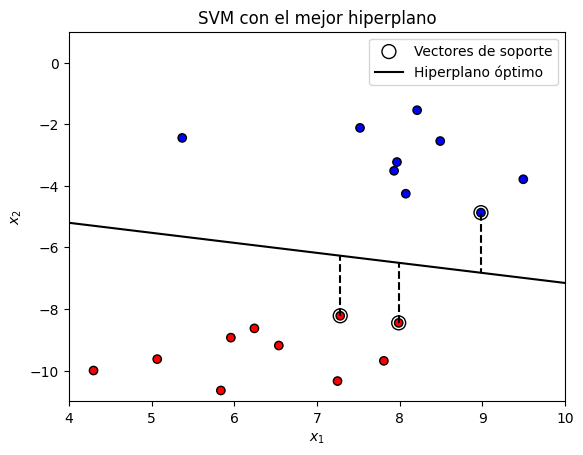

In [2]:
from sklearn.svm import SVC

# Crear y ajustar el modelo SVM
clf = SVC(kernel='linear', C=1e10)
clf.fit(X, y)

# Obtener los coeficientes del hiperplano
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(4, 10)
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')

# Dibujar los vectores de soporte
b = clf.support_vectors_
plt.scatter(b[:, 0], b[:, 1], s=100, facecolors='none', edgecolors='k', label='Vectores de soporte')

# Dibujar el mejor hiperplano
plt.plot(xx, yy, 'k-', label='Hiperplano óptimo')
# Dibujar líneas desde los vectores de soporte hasta el hiperplano
for i in range(len(b)):
    plt.plot([b[i, 0], b[i, 0]], [b[i, 1], a * b[i, 0] - (clf.intercept_[0]) / w[1]], 'k--')

plt.xlim(4, 10)
plt.ylim(-11, 1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('SVM con el mejor hiperplano')
plt.legend()
plt.show()


Hasta ahora, hemos hablando de datos linealmente separables (el grupo de círculos azules y círculos rojos son separables por una línea recta). ¿Qué hacer si los datos no son separables linealmente?

SVM resuelve esto creando una nueva variable usando un **kernel**.

Así, una estrategia para enfrentarse a escenarios en los que la separación de los grupos es de tipo _no lineal_ consiste en **expandir las dimensiones del espacio original**.

El hecho de que los grupos no sean linealmente separables en el espacio original no significa que no lo sean en un espacio de mayores dimensiones. Las imágenes siguientes muestran como dos grupos, cuya separación en dos dimensiones no es lineal, pero sí lo es al añadir una tercera dimensión.

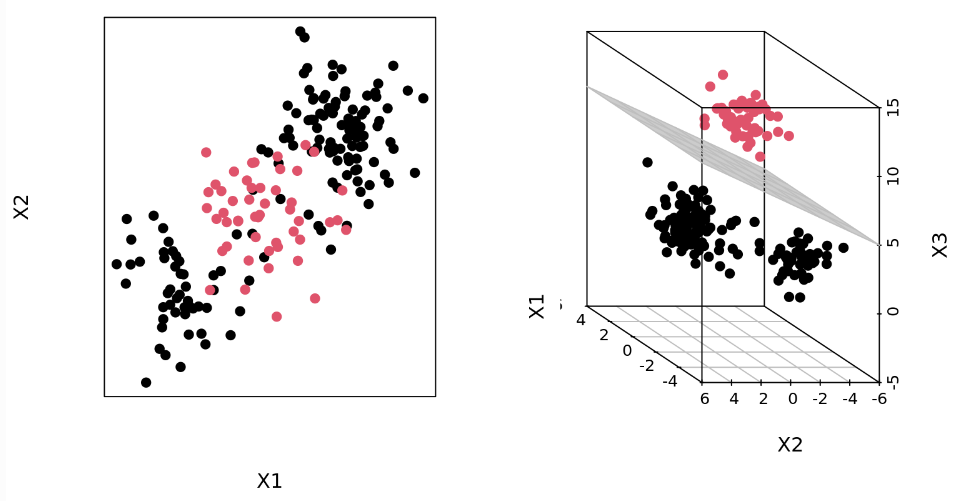

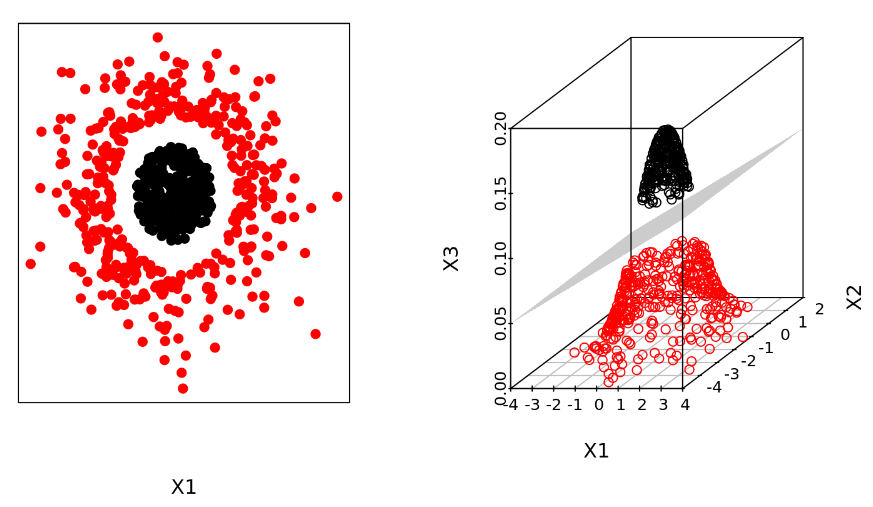

<a id="1.2"></a>
## 1.B Métodos de Kernel para Machine Learning

Los métodos de **kernel** son una colección de algoritmos de análisis de patrones que utilizan _funciones de kernel_ para operar en un espacio de características de alta dimensión. La aplicación más conocida de los métodos de kernel es SVM.

Los límites de decisión son hiperplanos en un espacio de alta dimensionalidad. La función de kernel mapea implícitamente los datos de entrada en este espacio dimensional superior, donde puede ser más fácil resolver el problema inicial. En otras palabras, los kernels pueden permitir que las distribuciones de datos que originalmente no eran separables linealmente se conviertan en un problema separable linealmente. Este es un efecto conocido como el **truco del kerne**.

### Funciones de Kernel

Matemáticamente, las funciones de kernel se ven como:

$$k(\vec{x}_i, \vec{x}_j)=\langle f(\vec{x}_i), f(\vec{x}_j) \rangle$$

donde 
- $k$ es la función de kernel
- $\vec{x}_i, \vec{x}_j$ son entradas $n$ dimensionales
- $f$ es un mapa del espacio $n$-dimensional al espacio $m$-dimensional 
- $\langle a,b\rangle$ denota el producto interno

Al considerar datos finitos, una función de kernel se puede representar como una matriz:

$$K_{ij}=k(\vec{x}_i, \vec{x}_j)$$

<a id="1.3"></a>
## 1.C Kernels cuánticos

La idea principal detrás del machine learning de kernel cuántico es aprovechar los mapas de características cuánticos para realizar el truco del kernel. En este caso, el kernel cuántico se crea asignando un vector de características clásico $\vec{x}$ a un espacio de Hilbert usando un mapa de características cuánticas $\phi(\vec{x})$. Matemáticamente esto es:

$$K_{ij}=|\langle\phi(\vec{x}_i) | \phi(\vec{x}_j)\rangle|^2$$

donde
- $K_{ij}$ es la matriz del kernel
- $\vec{x}_i, \vec{x}_j$ son entradas $n$ dimensionales
- $\phi(\vec{x})$ es el mapa de características cuántico
- $|\langle a|b\rangle|^2$ denota la superposición de dos estados cuánticos $a$ y $b$

Los kernels cuánticos se pueden conectar a algoritmos de aprendizaje de kernel clásicos comunes, como SVM o algoritmos de agrupamiento (clustering). También se pueden aprovechar en nuevos métodos de kernel cuánticos como la clase `QSVC` proporcionada por `qiskit-machine-learning`.

Los **kernels cuánticos** son una extensión de los kernels clásicos que aprovechan las propiedades de la computación cuántica para transformar los datos a un espacio de características de mayor dimensión, potencialmente logrando una mejor separación y clasificación. Razones por las cuales podríamos preferir un kernel cuántico sobre uno clásico:

1. **Mayor Capacidad de Representación**: Los kernels cuánticos pueden mapear los datos a un espacio de características mucho más elevado que los kernels clásicos. Este mayor espacio de características puede capturar relaciones complejas y no lineales de manera más efectiva.
2. **Acceso a Espacios de Características Inaccesibles Clásicamente:**: La computación cuántica puede explorar y utilizar espacios de características que son inalcanzables para las computadoras clásicas debido a su capacidad de procesar información en paralelo y su uso de qubits que pueden representar múltiples estados simultáneamente.
3. **Potencial de Ventaja Cuántica**: Teóricamente, algunos problemas de clasificación pueden ser resueltos más eficientemente utilizando kernels cuánticos debido a la naturaleza del procesamiento cuántico. Esto se refiere a la posibilidad de contar con algún tipo de ventaja cuántica, donde los algoritmos cuánticos superan a los mejores algoritmos clásicos en ciertos casos específicos.
4. **Robustez Frente a Datos Complejos**: Los kernels cuánticos pueden ser especialmente útiles para conjuntos de datos con estructuras intrincadas o distribuciones complejas que son difíciles de manejar con kernels clásicos. Ejemplos de esto incluyen datos de alta dimensionalidad, distribuciones con múltiples modos o datos con ruido estructurado.

<a id="1.4"></a>
## 1.D Clasificación

A continuación revisaremos el flujo de trabajo para la clasificación usando un kernel cuántico.

Los ejemplos utilizados en este tutorial se basan en este artículo de referencia: [Supervised learning with quantum enhanced feature spaces](https://arxiv.org/pdf/1804.11326.pdf).

In [3]:
# configuramos la semilla global para la reproducibilidad:

from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345

### Datos

Para este ejemplo, usaremos el conjunto de datos que ha sido específicamente creado para el propósito del ejemplo (_ad hoc_), como se describe en el artículo de referencia.

Podemos definir la dimensión del conjunto de datos y obtener nuestros subconjuntos de entrenamiento y prueba:

In [4]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

Este conjunto de datos es bidimensional, las dos características están representadas por las coordenadas 
$x,$ $y$, y tiene dos etiquetas: $A$ y $B$. Podemos graficarlo y ver cómo se ve la distribución.

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # gráfica de datos de entrenamiento tipo A
    ax.scatter(
        # coordenada 'x' de las etiquetas donde la clase es class_label
        features[np.where(labels[:] == class_label), 0],
        # coordenada 'y' de las etiquetas donde la clase es class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # gráfica de datos de entrenamiento tipo A
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "entrenamiento A")

    # gráfica de datos de entrenamiento tipo B
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "entrenamiento B")

    # gráfica de datos de prueba tipo A
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "prueba A")

    # gráfica de datos de prueba tipo B
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "prueba B")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Conjunto de datos")

    plt.show()

Ahora graficamos el conjunto de datos para la clasificación:

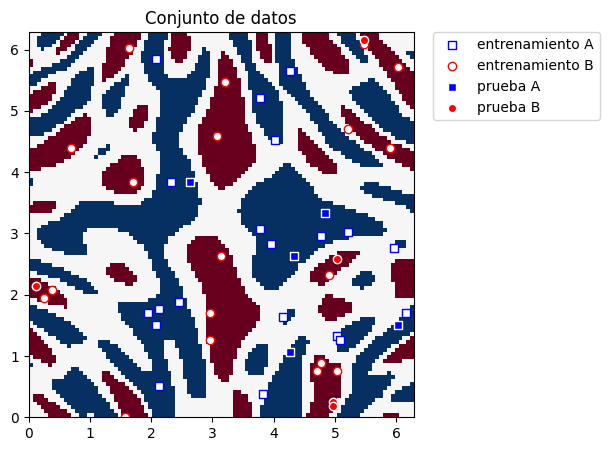

In [6]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### Definición del kernel cuántico

El siguiente paso es crear una instancia del kernel cuántico que ayude a clasificar estos datos.

Usamos la clase `FidelityQuantumKernel`, que define ña función de kernel como la superposición de dos estados cuánticos, y pasamos dos argumentos de entrada a su constructor:

1. `feature_map`: en este caso, un `ZZFeatureMap` de dos qubits.
2. `fidelity`: en este caso, la subrutina de fidelidad `ComputeUncompute` que aprovecha la primitiva `Sampler`.

Nota: Si no pasas una instancia `Sampler` o `Fidelity`, entonces las instancias de las clases de referencia `Sampler` y `ComputeUncompute` (que se encuentran en `qiskit.primitives`) serán creadas de forma predeterminada.

In [7]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

### Clasificación con SVC

El kernel cuántico ahora se puede conectar a _métodos de kernel clásicos_, como el algoritmo `SVC` de `scikit-learn`. Este algoritmo nos permite definir un kernel personalizado ([custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels)) de dos maneras:

1. proporcionando el kernel como una **función invocable**
2. precalculando la **matriz del kernel**

#### Kernel como una función invocable

Definimos un modelo `SVC` y pasamos directamente la función `evaluate` del kernel cuántico como un invocable. Una vez que se crea el modelo, lo entrenamos llamando al método `fit` en el conjunto de datos de entrenamiento y evaluamos la precisión del modelo con `score`.

In [8]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Puntuación de los datos de prueba de la clasificación con kernel invocable: {adhoc_score_callable_function}")

Puntuación de los datos de prueba de la clasificación con kernel invocable: 1.0


#### Matriz de kernel precalculada

En lugar de pasar una función de kernel cuántico como un invocable, también podemos calcular previamente las matrices del kernel de entrenamiento y prueba antes de pasarlas al algoritmo `SVC` de `scikit-learn`.

Para extraer las matrices de entrenamiento y prueba, podemos llamar a `evaluate` en el kernel previamente definido y visualizarlas gráficamente de la siguiente manera:

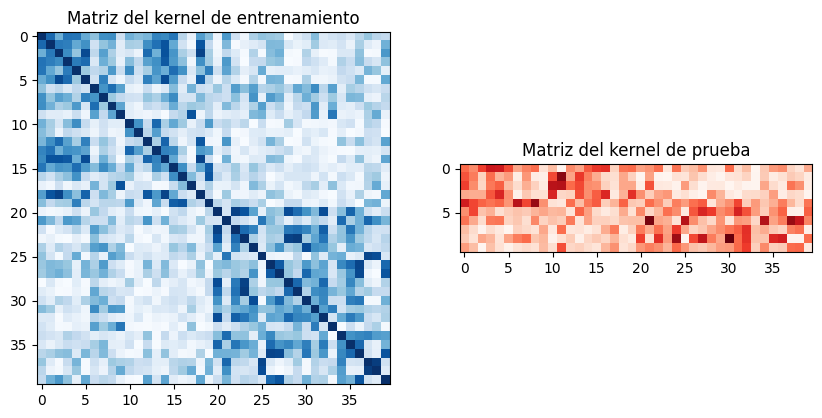

In [9]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Matriz del kernel de entrenamiento")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Matriz del kernel de prueba")

plt.show()

La matriz del kernel cuántico muestra cómo se relacionan los puntos de datos en el espacio transformado por el kernel. Observando esta matriz, se pueden identificar patrones de similitud y estructura en los datos, evaluar la efectividad del kernel cuántico y ajustar los parámetros del modelo para mejorar su rendimiento.

Los valores fuera de la diagonal principal indican la similitud entre diferentes puntos del conjunto de datos. Los valores más oscuros indican mayor similitud, mientras que los más claros indican menor similitud.

Para usar estas matrices, establecemos el parámetro `kernel` de una nueva instancia de `SVC` con `"precomputed"`. Entrenamos al clasificador llamando a `fit` con la matriz de entrenamiento y el conjunto de datos de entrenamiento. Una vez que se entrena el modelo, lo evaluamos usando la matriz de prueba en el conjunto de datos de prueba.

In [10]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Puntuación de los datos de prueba de la clasificación con kernel precalculado: {adhoc_score_precomputed_kernel}")

Puntuación de los datos de prueba de la clasificación con kernel precalculado: 1.0


### Clasificación con QSVC

`QSVC` es un algoritmo de entrenamiento alternativo proporcionado por `qiskit-machine-learning` para nuestra conveniencia. Es una extensión de `SVC` que acepta un kernel cuántico en lugar del método `kernel.evaluate` mostrado anteriormente.

In [11]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"Puntuación de los datos de prueba de clasificación con QSVC: {qsvc_score}")

Puntuación de los datos de prueba de clasificación con QSVC: 1.0


### Evaluación de modelos utilizados para la clasificación

In [12]:
print(f"Modelo de clasificación                      | Puntuación de precisión")
print(f"---------------------------------------------------------")
print(f"SVC con el kernel como una función invocable | {adhoc_score_callable_function:10.2f}")
print(f"SVC con la matriz de kernel precalculada     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                         | {qsvc_score:10.2f}")

Modelo de clasificación                      | Puntuación de precisión
---------------------------------------------------------
SVC con el kernel como una función invocable |       1.00
SVC con la matriz de kernel precalculada     |       1.00
QSVC                                         |       1.00


Como el conjunto de datos de clasificación es pequeño, encontramos que los tres modelos logran una precisión del $100\%$.

<a id="1.5"></a>
## 1.E Agrupación (Clustering)

Este otro ejemplo se centra en una tarea de **agrupamiento (clustering)** utilizando `qiskit-machine-learning` y el algoritmo de _agrupamiento espectral_ de `scikit-learn`.

El _agrupamiento espectral_ es una técnica de clustering que utiliza los valores y vectores propios (espectro) de una matriz asociada con los datos para realizar la agrupación. Es particularmente útil para identificar clusters en datos que no tienen una forma clara, como aquellos con formas no lineales o con estructuras complejas.

Los métodos de kernel son utilizados en el _agrupamiento espectral_. El uso de un kernel permite mapear los datos a un espacio de características de mayor dimensión, donde es más probable que sean linealmente separables. Este enfoque es particularmente útil en clustering espectral, donde los datos a menudo no son linealmente separables en su espacio original.

### Datos

Una vez más usaremos el conjunto de datos que ha sido específicamente creado para el propósito del ejemplo (ad hoc), pero ahora generado con una brecha mayor de `0.6` (en el ejemplo anterior usamos: `0.3`) entre las dos clases.

Ten en cuenta que la agrupación en clústeres se incluye en la categoría de _machine learning no supervisado_, por lo que no se requiere un conjunto de datos de prueba.

In [13]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

Graficamos el conjunto de datos de agrupamiento a continuación:

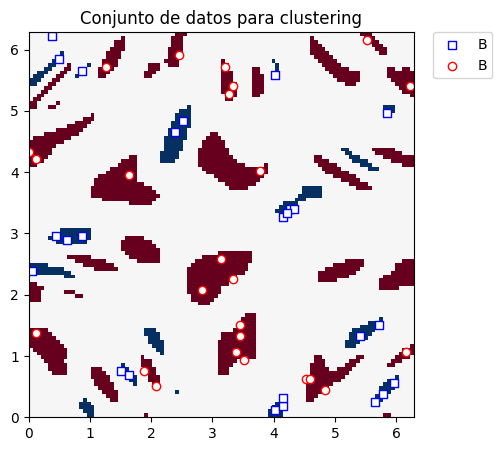

In [14]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# etiqueta A
plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "B")

# etiqueta B
plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Conjunto de datos para clustering")

plt.show()

### Definición del Kernel Cuántico

Usamos una configuración idéntica a la del ejemplo de clasificación. Creamos otra instancia de la clase `FidelityQuantumKernel` con un `ZZFeatureMap`, pero podemos notar que en este caso no proporcionamos una instancia de `fidelity`. Esto se debe a que el método `ComputeUncompute` proporcionado en el caso anterior es instanciado de forma predeterminada cuando la instancia de fidelidad no se proporciona explícitamente.

In [15]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

### Agrupamiento (Clustering) con el Modelo de Agrupamiento Espectral

El algoritmo de agrupamiento espectral de `scikit-learn` nos permite definir un kernel personalizado de dos maneras (al igual que `SVC`):

1. proporcionando el kernel como una **función invocable**
2. precalculando la **matriz del kernel**

Con la clase `FidelityQuantumKernel` actual en `qiskit-machine-learning`, solo podemos usar la última opción, por lo que precalculamos la matriz del kernel llamando a `evaluate` y la visualizamos de la siguiente manera:

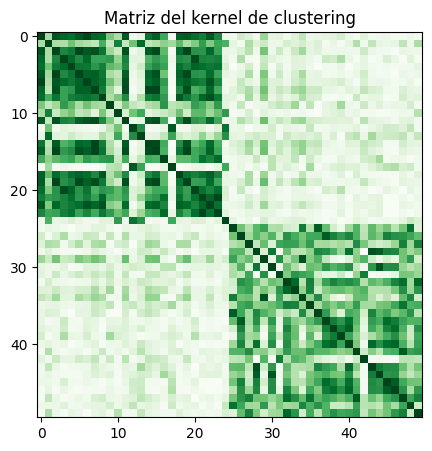

In [16]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(adhoc_matrix), interpolation="nearest", origin="upper", cmap="Greens")
plt.title("Matriz del kernel de clustering")
plt.show()

A continuación, definimos un modelo de agrupamiento espectral y lo ajustamos utilizando el kernel precalculado. Además, calificamos las etiquetas utilizando información mutua normalizada, ya que conocemos las etiquetas de clase a priori (de antemano).

In [17]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

adhoc_spectral = SpectralClustering(2, affinity="precomputed")

cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)

cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

print(f"Puntuación del clustering: {cluster_score}")

Puntuación del clustering: 0.7287008798015754


<a id="2"></a>
# 2. Red generativa adversativa

<a id="2.1"></a>
## 2.A Generative Adversarial Network (GAN)

Una **Generative Adversarial Network (GAN)** es un tipo de modelo de aprendizaje profundo compuesto por dos redes neuronales que compiten entre sí en un marco de juego de suma cero. Las GANs fueron introducidas por [Ian Goodfellow y sus colegas en 2014](https://arxiv.org/abs/1406.2661). Las dos redes que componen una GAN son:

1. **Generador (Generator)**:
    - Función: El generador toma un vector de ruido (normalmente una distribución aleatoria) y lo transforma en datos que imitan la distribución de datos reales.
    - Objetivo: Crear datos falsos que sean indistinguibles de los datos reales para el discriminador.
2. **Discriminador (Discriminator)**:
    - Función: El discriminador evalúa los datos recibidos y determina si son reales (provenientes del conjunto de datos de entrenamiento) o generados (provenientes del generador).
    - Objetivo: Diferenciar correctamente entre datos reales y datos generados.

### Entrenamiento

El proceso de entrenamiento de una GAN se asemeja a un _juego de dos jugadores_:

1. Entrenamiento del Generador:
    - El generador produce datos falsos a partir de un vector de ruido.
    - El objetivo del generador es engañar al discriminador para que clasifique estos datos falsos como reales.
2. Entrenamiento del Discriminador:
    - El discriminador recibe una mezcla de datos reales y datos generados.
    - El objetivo del discriminador es clasificar correctamente los datos como reales o generados.
3. Proceso Adversarial:
    - El generador mejora creando datos cada vez más realistas para engañar al discriminador.
    - Simultáneamente, el discriminador mejora su capacidad para distinguir entre datos reales y generados.
    - Este proceso continua hasta que el discriminador no pueda distinguir entre los datos reales y los datos generados con una alta precisión.

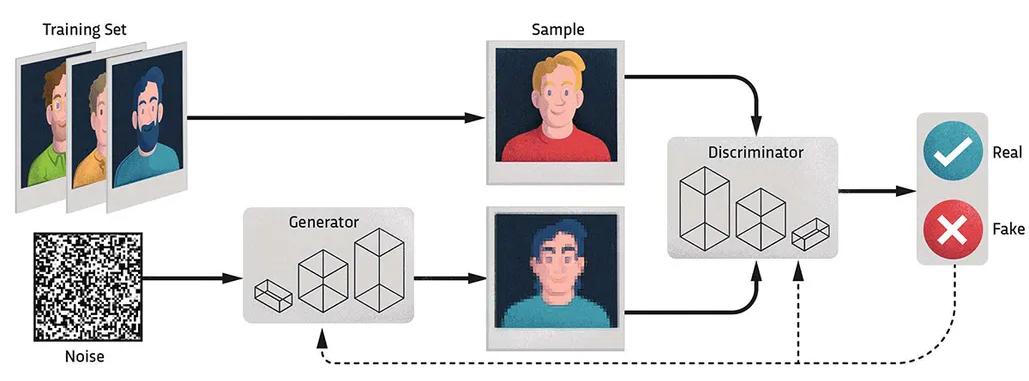

<a id="2.2"></a>
## 2.B Quantum GAN (qGAN)

El qGAN [Zoufal et al.](https://www.nature.com/articles/s41534-019-0223-2) es un algoritmo híbrido cuántico-clásico utilizado para tareas de modelado generativo. El algoritmo utiliza la interacción de un **generador cuántico** $G_{\theta}$, es decir, un ansatz (circuito cuántico parametrizado), y un **discriminador clásico** $D_{\phi}$, una red neuronal, para aprender la distribución de probabilidad subyacente dados los datos de entrenamiento.

El generador y el discriminador se entrenan en pasos de optimización alternantes, donde el generador apunta a generar probabilidades que serán clasificadas por el discriminador como valores de datos de entrenamiento (es decir, probabilidades de la distribución de entrenamiento real), y el discriminador trata de diferenciar entre distribución original y probabilidades del generador (en otras palabras, distinguir las distribuciones real y generada). El objetivo final es que el generador cuántico aprenda una representación para la distribución de probabilidad objetivo. El generador cuántico entrenado puede, por lo tanto, usarse para cargar un estado cuántico que es un modelo aproximado de la distribución objetivo.

### qGANs para Cargar Distribuciones Aleatorias

Dadas las muestras de datos $k$-dimensionales, empleamos una qGAN para conocer una distribución aleatoria y cargarla directamente en un estado cuántico:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

donde $p_{\theta}^{j}$ describen las probabilidades de ocurrencia de los estados base $\big| j\rangle$.

El objetivo del entrenamiento qGAN es generar un estado $\big| g_{\theta}\rangle$ donde $p_{\theta}^{j}$, para $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe una distribución de probabilidad cercana a la distribución subyacente a los datos de entrenamiento $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

Para obtener más detalles, consulta [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions Zoufal, Lucchi, Woerner (2019)](https://arxiv.org/abs/1904.00043).

Para un ejemplo de cómo utilizar una qGAN entrenada en una aplicación, la fijación de precios de derivados financieros, consulta el tutoria l[Option Pricing with qGANs](https://qiskit.org/ecosystem/finance/tutorials/10_qgan_option_pricing.html).

### Datos

Primero, necesitamos cargar nuestros datos de entrenamiento $X$.

En este tutorial, los datos de entrenamiento están dados por una distribución normal multivariante 2D.

El objetivo del generador es aprender a representar dicha distribución, y el generador entrenado debe corresponder a un estado cuántico de $n$ qubits

\begin{equation}
|g_{\text{trained}}\rangle=\sum\limits_{j=0}^{k-1}\sqrt{p_{j}}|x_{j}\rangle
\end{equation}

donde el estado base $|x_{j}\rangle$ representa los elementos de datos en el conjunto de datos de entrenamiento $X={x_0, \ldots, x_{k-1}}$ con $k\leq 2^n$ y $p_j$ se refiere a la probabilidad de muestreo de $|x_{j}\rangle$.

Para facilitar esta representación, necesitamos mapear las muestras de la distribución normal multivariante a valores discretos. La cantidad de valores que se pueden representar depende de la cantidad de qubits utilizados para el mapeo. Por lo tanto, la resolución de datos se define por el número de qubits. Si usamos $3$ qubits para representar una característica, tenemos $2^3=8$ valores discretos.

Primero comenzamos fijando semillas en los generadores de números aleatorios para la reproducibilidad del resultado en este tutorial.

In [18]:
import torch
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)

Fijamos el número de dimensiones, el número de discretización y calculamos el número de qubits requeridos como $2^3=8$.

In [19]:
import numpy as np

num_dim = 2
num_discrete_values = 8
num_qubits = num_dim * int(np.log2(num_discrete_values))

Luego, preparamos una distribución discreta a partir de la distribución normal 2D continua. Evaluamos la función de densidad de probabilidad continua (probability density function, PDF) en la cuadrícula $(-2,2)^2$ con una discretización de $8$ valores por función. Por lo tanto, tenemos $64$ valores de la PDF. Como esta será una distribución discreta, normalizamos las probabilidades obtenidas.

In [20]:
from scipy.stats import multivariate_normal

coords = np.linspace(-2, 2, num_discrete_values)
rv = multivariate_normal(mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], seed=algorithm_globals.random_seed)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data)

Visualicemos nuestra distribución. Es una buena distribución normal bivariada en forma de campana en una cuadrícula discreta.

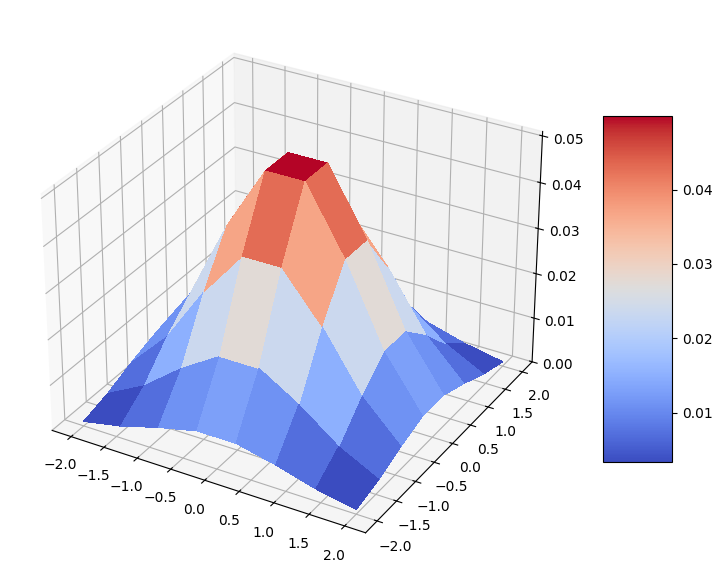

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Definiciones de las Redes Neuronales

En esta sección definimos dos redes neuronales como se mencionó anteriormente:

- Un generador cuántico como una red neuronal cuántica.
- Un discriminador clásico como una red neuronal basada en PyTorch.

#### Definición de la red neuronal cuántica ansatz

Ahora, definimos el circuito cuántico parametrizado $G\left(\boldsymbol{\theta}\right)$ con $\boldsymbol{\theta} = {\theta_1, ..., \theta_k}$ que será uilizado en nuestro generador cuántico.

Para implementar el generador cuántico, elegimos un ansatz eficiente en hardware con $6$ repeticiones. El ansatz implementa rotaciones $R_Y$, $R_Z$, y compuertas $CX$ que toman una distribución uniforme como estado de entrada. En particular, para 
 los parámetros del generador deben elegirse con cuidado. Por ejemplo, la profundidad del circuito debe ser mayor que $1$ porque las profundidades de circuito más altas permiten la representación de estructuras más complejas. Aquí, construimos un circuito bastante profundo con una gran cantidad de parámetros para poder capturar y representar adecuadamente la distribución.

In [22]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)

Dibujemos nuestro circuito y veamos cómo se ve. En la gráfica podemos notar un patrón que aparece $6$ veces.

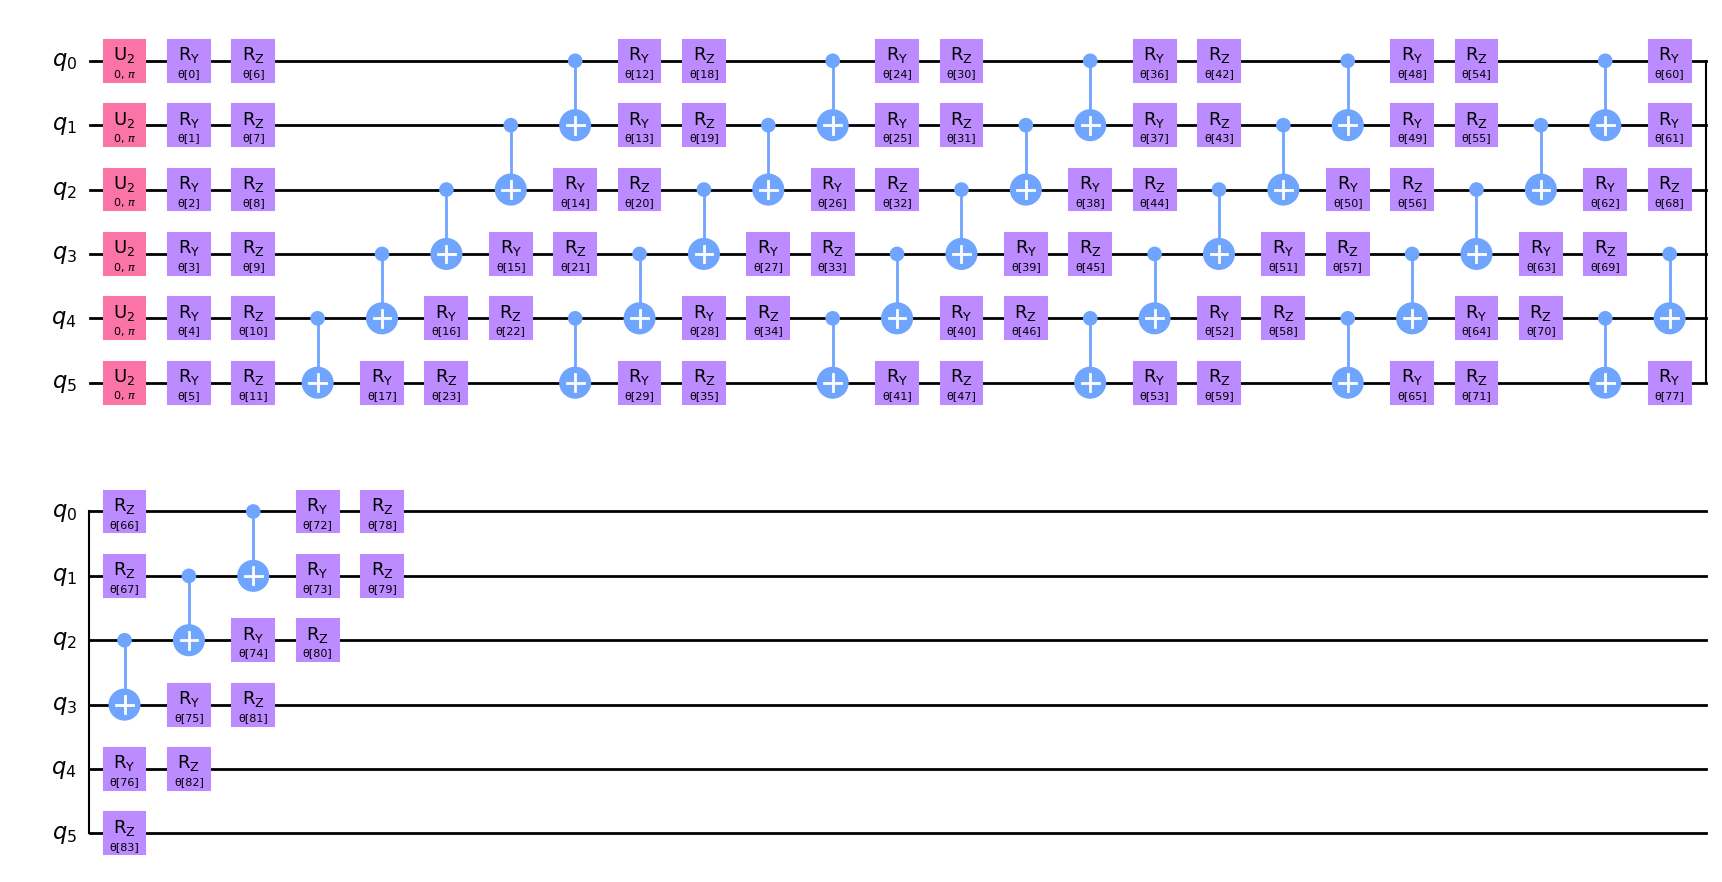

In [23]:
qc.decompose().draw("mpl")

Imprimamos el número de parámetros entrenables.

In [24]:
qc.num_parameters

84

#### Definición del generador cuántico

Comenzamos definiendo el generador creando un muestreador para el ansatz. La implementación de referencia está basada en vector de estado, por lo que devuelve probabilidades exactas como resultado de la ejecución del circuito. Agregamos el parámetro `shots` para agregar algo de ruido a los resultados. En este caso, la implementación muestra probabilidades de la distribución multinomial construida a partir de las cuasi probabilidades medidas. Y, como de costumbre, fijamos la semilla con fines de reproducibilidad.

In [25]:
from qiskit.primitives import Sampler

shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

A continuación, definimos una función que crea el generador cuántico a partir de un circuito cuántico parametrizado dado. Dentro de esta función, creamos una red neuronal que devuelve la distribución de cuasi probabilidad evaluada por el Sampler subyacente. Fijamos `initial_weights` con fines de reproducibilidad. Al final, envolvemos la red neuronal cuántica creada en `TorchConnector` para hacer uso del entrenamiento basado en PyTorch.

In [26]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

#### Definición del discriminador clásico

Después, definimos una red neuronal clásica basada en PyTorch que representa el discriminador clásico. Los gradientes subyacentes se pueden calcular automáticamente con PyTorch.

In [27]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

#### Crear un generador y un discriminado

Ahora creamos un generador y un discriminador.

In [28]:
generator = create_generator()
discriminator = Discriminator(num_dim)

### Configuración del Ciclo de Entrenamiento

En esta sección configuramos:

- Una función de pérdida para el generador y el discriminador.
- Optimizadores para ambos.
- Una función de utilidad de graficado para visualizar el proceso de entrenamiento.

#### Definición de las funciones de pérdida

Queremos entrenar el generador y el discriminador con entropía cruzada binaria como la función de pérdida:

$$L\left(\boldsymbol{\theta}\right)=\sum_jp_j\left(\boldsymbol{\theta}\right)\left[y_j\log(x_j) + (1-y_j)\log(1-x_j)\right]$$

donde $x_j$ se refiere a una muestra de datos, mientras que $y_j$ a la etiqueta correspondiente.

Dado que `binary_cross_entropy` de PyTorch no es diferenciable con respecto a los pesos, implementamos la función de pérdida manualmente para poder evaluar gradientes.

In [29]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

#### Definición de los optimizadores

Para entrenar el generador y el discriminador, necesitamos definir esquemas de optimización. A continuación, empleamos un optimizador basado en el momento llamado Adam, consulta [Kingma et al., Adam: A method for stochastic optimization](https://arxiv.org/abs/1412.6980) para obtener más detalles.

In [30]:
from torch.optim import Adam

lr = 0.01   # tasa de aprendizaje
b1 = 0.7    # parámetro de primer momento
b2 = 0.999  # parámetro de segundo momento

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

#### Visualización del proceso de entrenamiento

Visualizaremos lo que sucede durante el entrenamiento graficando la evolución de las funciones de pérdida del generador y del discriminador durante el entrenamiento, así como el progreso en la entropía relativa entre la distribución entrenada y objetivo. Definimos una función que grafique las funciones de pérdida y la entropía relativa. Llamamos a esta función una vez que se completa una época de entrenamiento.

La visualización del proceso de entrenamiento comienza cuando los datos de entrenamiento se recopilan en dos épocas.

In [31]:
from IPython.display import clear_output


def plot_training_progress():
    #no graficamos si no tenemos datos suficientes
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # pérdida del Generador
    ax1.set_title("Pérdida")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteración")
    ax1.set_ylabel("Pérdida")
    ax1.grid()

    # Entropía relativa
    ax2.set_title("Entropía relativa")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteración")
    ax2.set_ylabel("Entropía relativa")
    ax2.grid()

    plt.show()

### Entrenamiento del Modelo

En el ciclo de entrenamiento monitoreamos no solo las funciones de pérdida, sino también la entropía relativa. La entropía relativa describe una métrica de distancia para las distribuciones. Por lo tanto, podemos usarla para comparar qué tan cerca/lejos está la distribución entrenada de la distribución objetivo.

Ahora, estamos listos para entrenar nuestro modelo. Puede llevar algo de tiempo entrenar al modelo, así que ten paciencia.

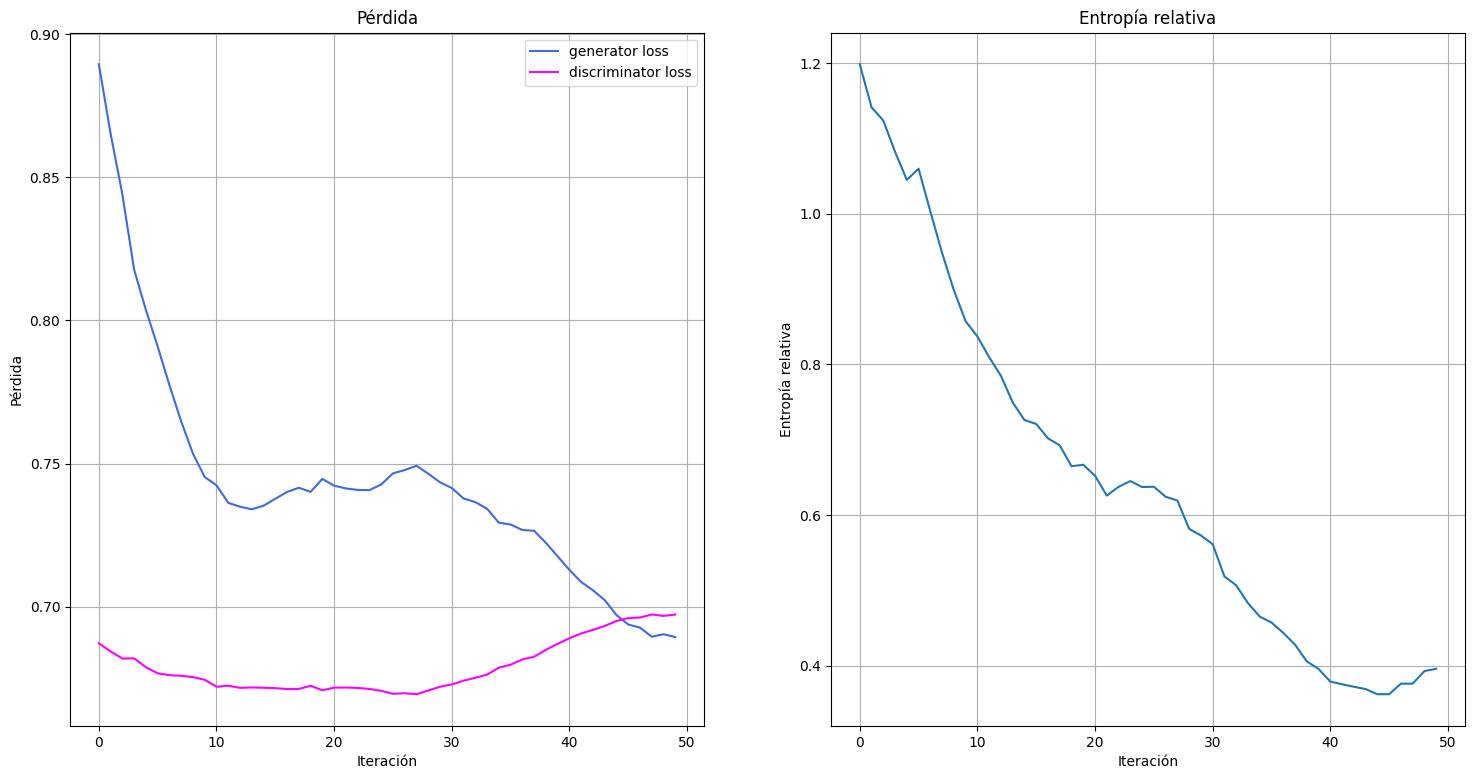

Ajuste en 190.68 segundos


In [32]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 50

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configurar entrada
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configurar muestras
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generar datos
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Entrenar al generador
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # almacenar para graficar
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Entrenar discriminador
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # almacenar para graficar
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Ajuste en {elapsed:0.2f} segundos")

### Resultados: Funciones de Densidad Acumulativa

En esta sección, comparamos la función de distribución acumulativa (cumulative distribution function, CDF) de la distribución entrenada con la CDF de la distribución objetivo.

Primero, generamos una nueva distribución de probabilidad con el autograd de PyTorch desactivado, ya que no vamos a entrenar más el modelo.

In [33]:
with torch.no_grad():
    generated_probabilities = generator().numpy()

Y luego, graficamos las funciones de distribución acumulativa de la distribución generada, la distribución original y la diferencia entre ellas. Ten cuidado, la escala en la tercera gráfica **no es la misma** que en la primera y segunda gráfica, y la diferencia real entre las dos CDF graficadas es bastante pequeña.

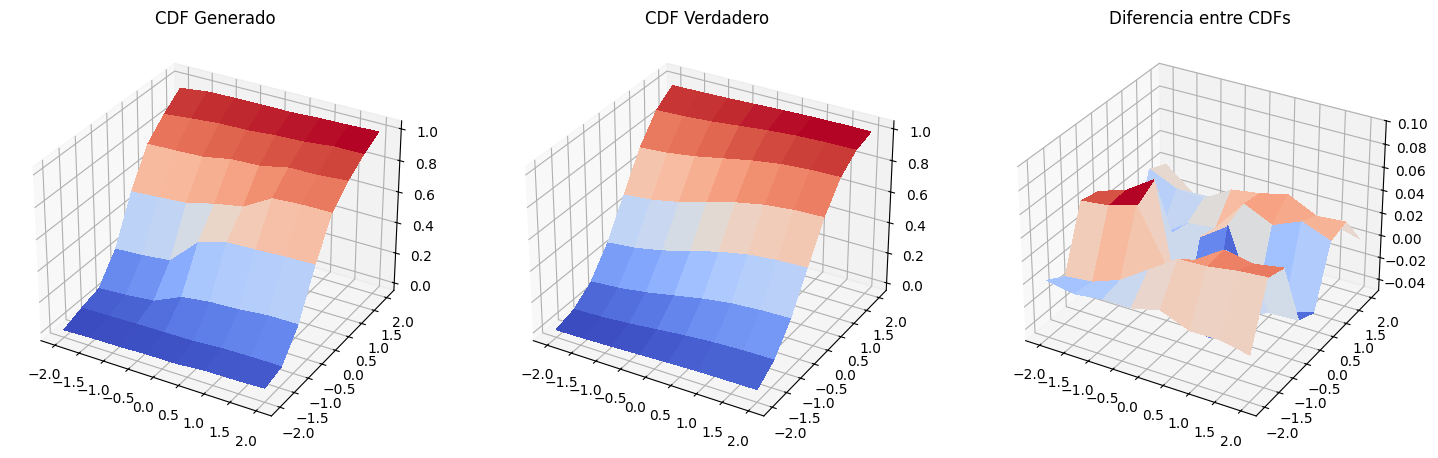

In [34]:
fig = plt.figure(figsize=(18, 9))

# CDF generado
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("CDF Generado")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# CDF real
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("CDF Verdadero")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# diferencia
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Diferencia entre CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()

Las redes de adversarios generativos cuánticas emplean la interacción de un generador y un discriminador para mapear una representación aproximada de una distribución de probabilidad subyacente a muestras de datos dadas en un canal cuántico. Este ejemplo presenta una implementación autónoma de qGAN basada en PyTorch, donde el generador está dado por un canal cuántico, es decir, un circuito cuántico variacional, y el discriminador por una red neuronal clásica, y analiza la aplicación de aprendizaje eficiente y carga de distribuciones de probabilidad genéricas en estados cuánticos. La carga requiere $\mathscr{O}\left(poly\left(n\right)\right)$ compuertas y, por lo tanto, puede permitir el uso de algoritmos cuánticos potencialmente ventajosos.